In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session"""

/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/3419_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/4176_right.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/3370_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/1255_right.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/660_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/484_right.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/4221_right.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/2396_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/543_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/3017_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/1482_left.jpg
/kaggle/input/ocular-disease-recognit

In [11]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/ocular-disease-recognition-odir5k")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ocular-disease-recognition-odir5k


In [12]:

import os
path="/kaggle/input/ocular-disease-recognition-odir5k"
base_path = path  # ← use the same variable, do NOT rewrite manually


In [13]:
import os

base_path = os.path.join(path, "ODIR-5K", "ODIR-5K")

labels_file = os.path.join(base_path, "data.xlsx")
train_images_folder = os.path.join(base_path, "Training Images")
test_images_folder = os.path.join(base_path, "Testing Images")

In [14]:
import pandas as pd

df = pd.read_excel(labels_file)
print(df.head())

   ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   3           66        Male  3_left.jpg  3_right.jpg   
4   4           53        Male  4_left.jpg  4_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                                      normal fundus   
4                        macular epiretinal membrane   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  
0                           normal fundus  0  0  0  1  0  0  0  0  
1                           normal fundus  1  0  0  0  0  0  0  0  
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1  
3         branch retinal artery occl

In [15]:
!pip install -q timm albumentations

import os
import shutil
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from tqdm.auto import tqdm
import timm 
from torch.optim.lr_scheduler import OneCycleLR


# SMART FILE DISCOVERY (Auto-Detect)
 
print("Searching for dataset files...")

CSV_PATH = None
IMG_SOURCE_DIR = None

# Find CSV
for root, dirs, files in os.walk('/kaggle/input'):
    for file in files:
        if file == "full_df.csv":
            CSV_PATH = os.path.join(root, file)
            
    #  Find Image Folder (Look for folder with 'preprocessed' or 'Training')
    # We verify by checking if it contains jpg/png files
    if not IMG_SOURCE_DIR:
        img_files = [f for f in files if f.lower().endswith(('.jpg', '.png'))]
        if len(img_files) > 500: # If folder has many images
            IMG_SOURCE_DIR = root

if not CSV_PATH or not IMG_SOURCE_DIR:
    raise ValueError("Could not find 'full_df.csv' or the image folder. Check dataset.")

print(f"Found CSV: {CSV_PATH}")
print(f"Found Images: {IMG_SOURCE_DIR}")

# Copy to Temp (Speed up training)
LOCAL_IMG_PATH = '/kaggle/temp/images'
if os.path.exists(LOCAL_IMG_PATH): shutil.rmtree(LOCAL_IMG_PATH)
os.makedirs(LOCAL_IMG_PATH, exist_ok=True)

print(f"Copying images to fast storage")
# Python copy to avoid command line errors
files_to_copy = [f for f in os.listdir(IMG_SOURCE_DIR) if f.lower().endswith(('.jpg', '.png'))]
for f in tqdm(files_to_copy, desc="Copying"):
    shutil.copy2(os.path.join(IMG_SOURCE_DIR, f), os.path.join(LOCAL_IMG_PATH, f))

print("Copy Complete")


# DATA PROCESSING & OVERSAMPLING

df = pd.read_csv(CSV_PATH)
LABELS = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

# ODIR-5K CSV usually has 'Left-Fundus' and 'Right-Fundus' columns
# We need to flatten this so each row is 1 image
print("Processing Patient Data into Image Data...")

left_df = df[['Left-Fundus'] + LABELS].rename(columns={'Left-Fundus': 'filename'})
right_df = df[['Right-Fundus'] + LABELS].rename(columns={'Right-Fundus': 'filename'})
full_df = pd.concat([left_df, right_df], axis=0).reset_index(drop=True)

# Verify filenames exist
full_df['path'] = full_df['filename'].apply(lambda x: os.path.join(LOCAL_IMG_PATH, x))
full_df = full_df[full_df['path'].apply(os.path.exists)] # Keep only valid images

print(f"Total Images Before Balancing: {len(full_df)}")

# --- OVERSAMPLING LOGIC ---
# We split FIRST to ensure no data leakage (validation set must remain pure)
train_df, val_df = train_test_split(full_df, test_size=0.2, random_state=42)

print("Applying Oversampling to Training Data...")
TARGET_COUNT = 2000 # Aim for 2000 images per class
resampled_dfs = []

# For Normal class, we just take it as is (or downsample if too huge)
normal_df = train_df[train_df['N'] == 1]
resampled_dfs.append(normal_df) 

for label in LABELS:
    if label == 'N': continue # Skip Normal
    
    disease_df = train_df[train_df[label] == 1]
    count = len(disease_df)
    
    if count == 0: continue # Skip if no images
    
    # If count is less than target, duplicate rows
    if count < TARGET_COUNT:
        oversampled = disease_df.sample(TARGET_COUNT, replace=True, random_state=42)
        resampled_dfs.append(oversampled)
    else:
        resampled_dfs.append(disease_df)

# Combine and Shuffle
train_df_balanced = pd.concat(resampled_dfs).sample(frac=1, random_state=42).reset_index(drop=True)
print(f"Balanced Training Set Size: {len(train_df_balanced)}")

 
# 4. DATASET & AUGMENTATION
 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Strong Augmentation is vital because we duplicated images
train_transforms = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.CLAHE(clip_limit=2.0, p=0.5), # Highlights blood vessels
    A.CoarseDropout(max_holes=8, max_height=20, max_width=20, p=0.2),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

class ODIRDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.label_cols = LABELS
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        try:
            image = np.array(Image.open(row['path']).convert("RGB"))
            if self.transform: image = self.transform(image=image)["image"]
            return image, torch.tensor(row[self.label_cols].values.astype(np.float32))
        except: return torch.zeros((3, 256, 256)), torch.zeros(8)

train_loader = DataLoader(ODIRDataset(train_df_balanced, train_transforms), batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(ODIRDataset(val_df, val_transforms), batch_size=32, shuffle=False, num_workers=0)

 
# PRETRAINED MAXVIT Modal (Novelty)
 
class CoordinateAttention(nn.Module):
    def __init__(self, inp, reduction=32):
        super().__init__()
        self.pool_h = nn.AdaptiveAvgPool2d((None, 1))
        self.pool_w = nn.AdaptiveAvgPool2d((1, None))
        mip = max(8, inp // reduction)
        self.conv1 = nn.Conv2d(inp, mip, 1); self.bn1 = nn.BatchNorm2d(mip); self.act = nn.SiLU()
        self.conv_h = nn.Conv2d(mip, inp, 1); self.conv_w = nn.Conv2d(mip, inp, 1)
    def forward(self, x):
        n,c,h,w = x.size()
        x_h, x_w = self.pool_h(x), self.pool_w(x).permute(0, 1, 3, 2)
        y = torch.cat([x_h, x_w], dim=2)
        y = self.act(self.bn1(self.conv1(y)))
        x_h, x_w = torch.split(y, [h, w], dim=2)
        a_h, a_w = torch.sigmoid(self.conv_h(x_h)), torch.sigmoid(self.conv_w(x_w.permute(0, 1, 3, 2)))
        return x * a_w * a_h

class HybridMaxViT(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        print("Loading MaxViT")
        self.backbone = timm.create_model('maxvit_rmlp_tiny_rw_256', pretrained=True, num_classes=0)
        self.attn = CoordinateAttention(512) # MaxViT Tiny outputs 512 channels
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.SiLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.backbone.forward_features(x)
        x = self.attn(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        return self.head(x)

model = HybridMaxViT(8).to(DEVICE)

 
# 6. TRAINING LOOP

# Since we oversampled, we can use Standard BCE Loss
criterion = nn.BCEWithLogitsLoss() 
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-3)
scheduler = OneCycleLR(optimizer, max_lr=2e-4, steps_per_epoch=len(train_loader), epochs=20)
scaler = torch.amp.GradScaler('cuda')

EPOCHS = 20
THRESHOLD = 0.5 
best_f1 = 0.0

def get_smart_preds(probs, thresh=0.5):
    preds = np.zeros_like(probs)
    for i in range(len(probs)):
        p = probs[i]
        if p[0] > 0.75: preds[i,0]=1; continue
        passed = (p > thresh).astype(int)
        if passed.sum() == 0: preds[i, np.argmax(p)] = 1
        else: preds[i] = passed
    return preds

print("\nStarting Training (Balanced Data)...")

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for img, lbl in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        img, lbl = img.to(DEVICE), lbl.to(DEVICE)
        with torch.amp.autocast('cuda'):
            outputs = model(img)
            loss = criterion(outputs, lbl)
        
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer); scaler.update(); scheduler.step()
        train_loss += loss.item()

    model.eval()
    val_probs, val_targets = [], []
    with torch.no_grad():
        for img, lbl in val_loader:
            img = img.to(DEVICE)
            outputs = model(img)
            val_probs.extend(torch.sigmoid(outputs).cpu().numpy())
            val_targets.extend(lbl.numpy())

    val_probs = np.array(val_probs)
    val_targets = np.array(val_targets).astype(int)
    val_preds = get_smart_preds(val_probs, THRESHOLD)
    
    f1 = f1_score(val_targets, val_preds, average='weighted', zero_division=0)
    prec = precision_score(val_targets, val_preds, average='weighted', zero_division=0)
    rec = recall_score(val_targets, val_preds, average='weighted', zero_division=0)
    acc = (val_preds == val_targets).mean()
    
    print(f"Epoch {epoch+1}: Loss {train_loss/len(train_loader):.4f}")
    print(f"   F1: {f1:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | Acc: {acc:.4f}")
    
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), "best_maxvit.pth")
        print("Model Saved")

# Report
model.load_state_dict(torch.load("best_maxvit.pth"))
model.eval()
print("\nFinal Report:")
print(classification_report(val_targets, val_preds, target_names=LABELS, zero_division=0))

Searching for dataset files...
Found CSV: /kaggle/input/ocular-disease-recognition-odir5k/full_df.csv
Found Images: /kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images
Copying images to fast storage


Copying:   0%|          | 0/6392 [00:00<?, ?it/s]

Copy Complete
Processing Patient Data into Image Data...
Total Images Before Balancing: 12460
Applying Oversampling to Training Data...
Balanced Training Set Size: 18994
Loading MaxViT


/tmp/ipykernel_47/4216223666.py:124: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=20, max_width=20, p=0.2),



Starting Training (Balanced Data)...


Epoch 1:   0%|          | 0/594 [00:00<?, ?it/s]

Epoch 1: Loss 0.4239
   F1: 0.4171 | Prec: 0.5115 | Rec: 0.4554 | Acc: 0.8619
Model Saved


Epoch 2:   0%|          | 0/594 [00:00<?, ?it/s]

Epoch 2: Loss 0.2834
   F1: 0.5800 | Prec: 0.6477 | Rec: 0.5595 | Acc: 0.8840
Model Saved


Epoch 3:   0%|          | 0/594 [00:00<?, ?it/s]

Epoch 3: Loss 0.2204
   F1: 0.6127 | Prec: 0.6410 | Rec: 0.6082 | Acc: 0.8883
Model Saved


Epoch 4:   0%|          | 0/594 [00:00<?, ?it/s]

Epoch 4: Loss 0.1823
   F1: 0.6201 | Prec: 0.6833 | Rec: 0.6113 | Acc: 0.8934
Model Saved


Epoch 5:   0%|          | 0/594 [00:00<?, ?it/s]

Epoch 5: Loss 0.1591
   F1: 0.6564 | Prec: 0.6920 | Rec: 0.6622 | Acc: 0.8988
Model Saved


Epoch 6:   0%|          | 0/594 [00:00<?, ?it/s]

Epoch 6: Loss 0.1375
   F1: 0.6649 | Prec: 0.7430 | Rec: 0.6705 | Acc: 0.9092
Model Saved


Epoch 7:   0%|          | 0/594 [00:00<?, ?it/s]

Epoch 7: Loss 0.1203
   F1: 0.7293 | Prec: 0.7383 | Rec: 0.7268 | Acc: 0.9226
Model Saved


Epoch 8:   0%|          | 0/594 [00:00<?, ?it/s]

Epoch 8: Loss 0.1026
   F1: 0.7315 | Prec: 0.7515 | Rec: 0.7355 | Acc: 0.9217
Model Saved


Epoch 9:   0%|          | 0/594 [00:00<?, ?it/s]

Epoch 9: Loss 0.0907
   F1: 0.7688 | Prec: 0.7712 | Rec: 0.7759 | Acc: 0.9322
Model Saved


Epoch 10:   0%|          | 0/594 [00:00<?, ?it/s]

Epoch 10: Loss 0.0697
   F1: 0.7712 | Prec: 0.7748 | Rec: 0.7873 | Acc: 0.9328
Model Saved


Epoch 11:   0%|          | 0/594 [00:00<?, ?it/s]

Epoch 11: Loss 0.0574
   F1: 0.8097 | Prec: 0.8067 | Rec: 0.8185 | Acc: 0.9440
Model Saved


Epoch 12:   0%|          | 0/594 [00:00<?, ?it/s]

Epoch 12: Loss 0.0450
   F1: 0.8184 | Prec: 0.8220 | Rec: 0.8285 | Acc: 0.9464
Model Saved


Epoch 13:   0%|          | 0/594 [00:00<?, ?it/s]

Epoch 13: Loss 0.0339
   F1: 0.8693 | Prec: 0.8787 | Rec: 0.8648 | Acc: 0.9625
Model Saved


Epoch 14:   0%|          | 0/594 [00:00<?, ?it/s]

Epoch 14: Loss 0.0266
   F1: 0.8825 | Prec: 0.8806 | Rec: 0.8862 | Acc: 0.9660
Model Saved


Epoch 15:   0%|          | 0/594 [00:00<?, ?it/s]

Epoch 15: Loss 0.0196
   F1: 0.8921 | Prec: 0.8996 | Rec: 0.8866 | Acc: 0.9690
Model Saved


Epoch 16:   0%|          | 0/594 [00:00<?, ?it/s]

Epoch 16: Loss 0.0128
   F1: 0.9046 | Prec: 0.9145 | Rec: 0.8983 | Acc: 0.9727
Model Saved


Epoch 17:   0%|          | 0/594 [00:00<?, ?it/s]

Epoch 17: Loss 0.0080
   F1: 0.9090 | Prec: 0.9191 | Rec: 0.9025 | Acc: 0.9740
Model Saved


Epoch 18:   0%|          | 0/594 [00:00<?, ?it/s]

Epoch 18: Loss 0.0055
   F1: 0.9132 | Prec: 0.9230 | Rec: 0.9070 | Acc: 0.9752
Model Saved


Epoch 19:   0%|          | 0/594 [00:00<?, ?it/s]

Epoch 19: Loss 0.0045
   F1: 0.9160 | Prec: 0.9276 | Rec: 0.9077 | Acc: 0.9761
Model Saved


Epoch 20:   0%|          | 0/594 [00:00<?, ?it/s]

Epoch 20: Loss 0.0038
   F1: 0.9125 | Prec: 0.9235 | Rec: 0.9042 | Acc: 0.9751

Final Report:
              precision    recall  f1-score   support

           N       0.89      0.96      0.92       805
           D       0.95      0.93      0.94       859
           G       0.95      0.90      0.92       155
           C       0.93      0.92      0.92       144
           A       0.89      0.80      0.84       125
           H       0.93      0.78      0.85        83
           M       0.96      0.94      0.95       123
           O       0.93      0.83      0.88       598

   micro avg       0.92      0.90      0.91      2892
   macro avg       0.93      0.88      0.90      2892
weighted avg       0.92      0.90      0.91      2892
 samples avg       0.92      0.91      0.91      2892



predictions for visualization...
Plotting...
Plotting ROC Curves...


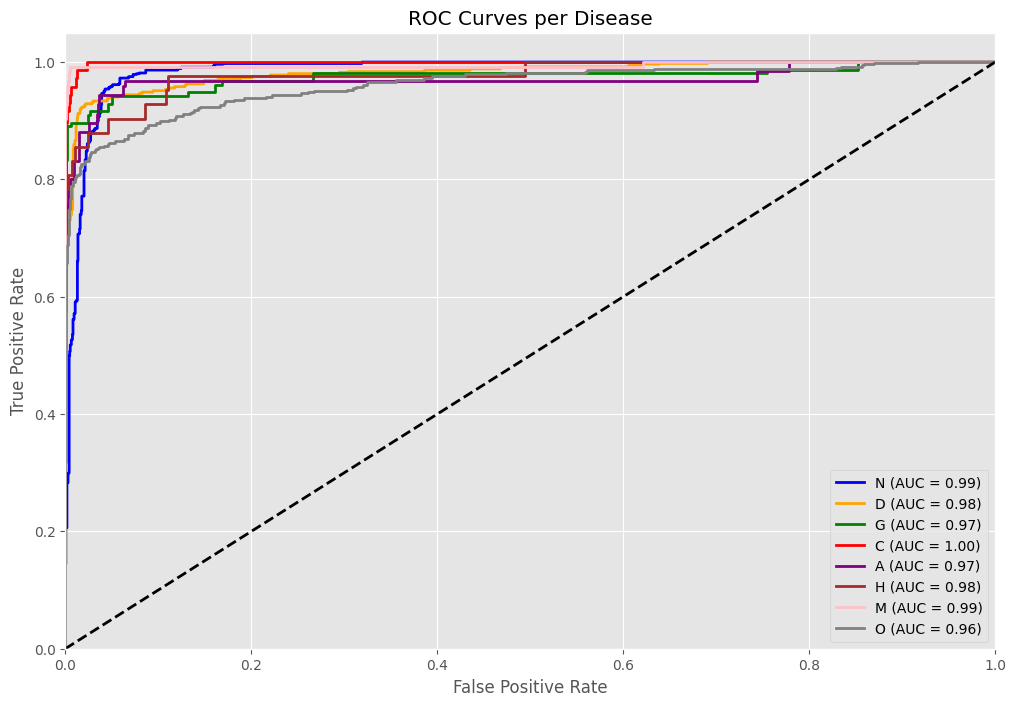

Plotting Confusion Matrices...


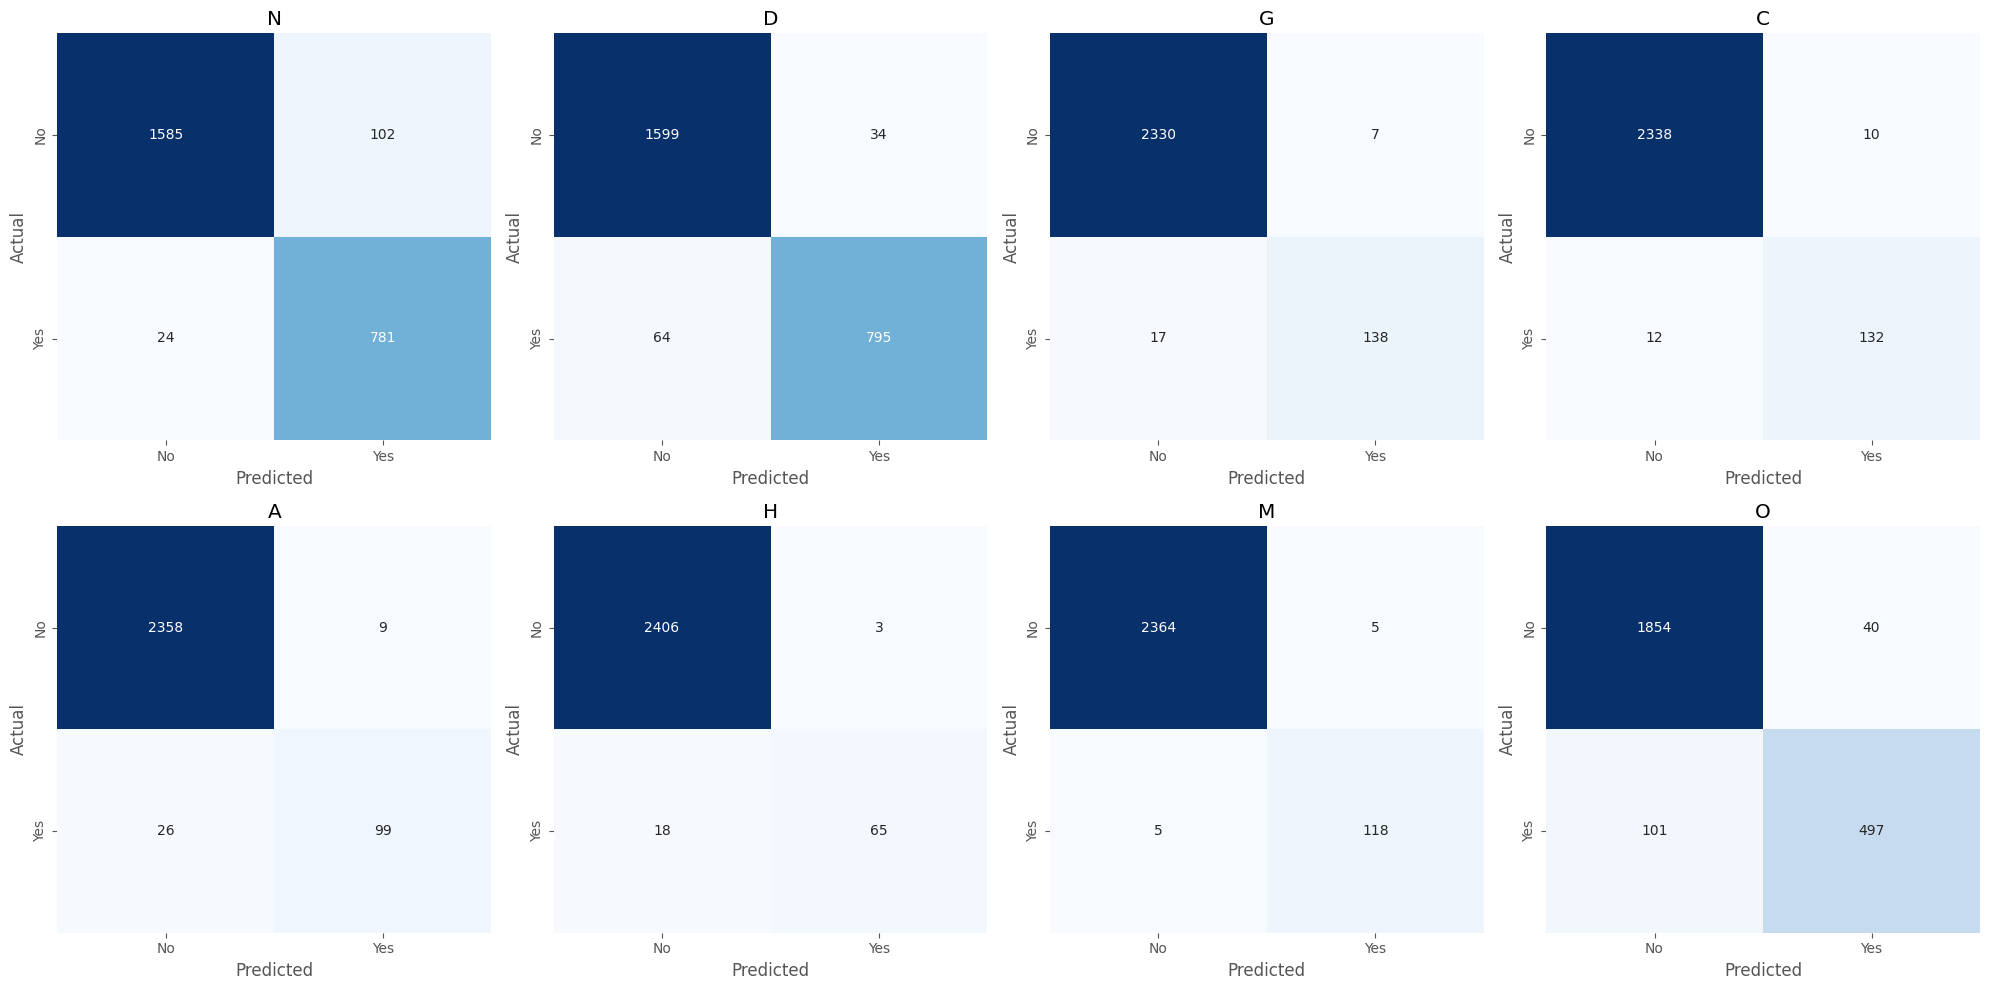

Showing Sample Predictions...


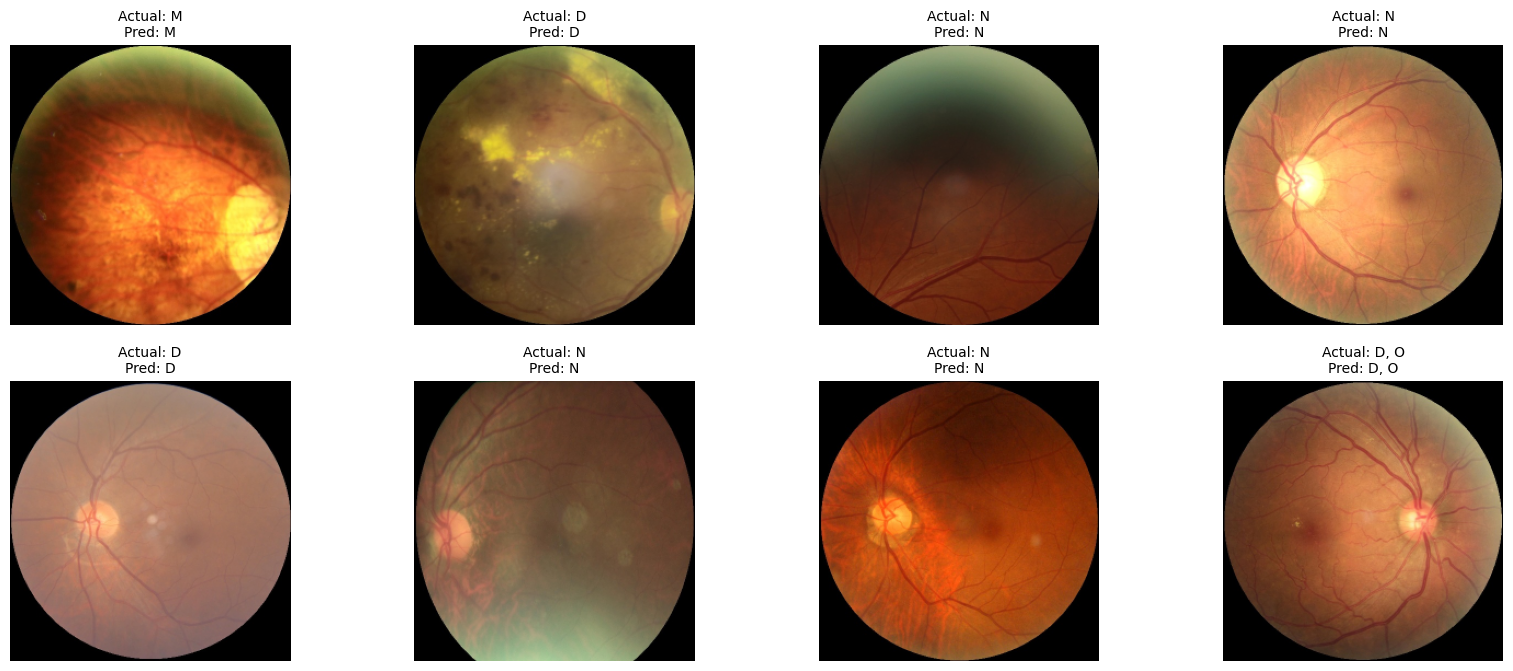

In [24]:
 
# 8. VISUALIZATION & ANALYSIS (IMPRESS THE PROF)
 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix
import numpy as np
import torch

 
 
print("predictions for visualization...")

# Load best weights
if os.path.exists("best_custom_model.pth"):
    model.load_state_dict(torch.load("best_custom_model.pth"))
model.eval()

final_probs = []
final_targets = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        # Get Probabilities
        final_probs.extend(torch.sigmoid(outputs).cpu().numpy())
        final_targets.extend(labels.numpy())

final_probs = np.array(final_probs)
final_targets = np.array(final_targets).astype(int)

print("Plotting...")

# PLOTS
plt.style.use('ggplot')

#  ROC CURVES (Per Class)
print("Plotting ROC Curves...")
plt.figure(figsize=(12, 8))

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']
for i, label in enumerate(LABELS):
    fpr, tpr, _ = roc_curve(final_targets[:, i], final_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2) # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves per Disease')
plt.legend(loc="lower right")
plt.show()

# CONFUSION MATRICES  
print("Plotting Confusion Matrices...")

# Redefine helper function just in case
def get_smart_preds(probs, threshold=0.5):
    preds = np.zeros_like(probs)
    for i in range(len(probs)):
        p = probs[i]
        if p[0] > 0.75: # Normal Rule
            preds[i, 0] = 1
            preds[i, 1:] = 0
            continue
        passed = (p > threshold).astype(int)
        if passed.sum() == 0: # Safety Net
            preds[i, np.argmax(p)] = 1
        else:
            preds[i] = passed
    return preds

# Use the threshold defined previously (defaulting to 0.5 if missing)
try:
    current_thresh = THRESHOLD 
except NameError:
    current_thresh = 0.5

final_preds_bin = get_smart_preds(final_probs, current_thresh)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, label in enumerate(LABELS):
    cm = confusion_matrix(final_targets[:, i], final_preds_bin[:, i])
    
    # Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
    axes[i].set_title(f'{label}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
    axes[i].set_xticklabels(['No', 'Yes'])
    axes[i].set_yticklabels(['No', 'Yes'])

plt.tight_layout()
plt.show()

# VISUAL PREDICTIONS
print("Showing Sample Predictions...")

# Helper to un-normalize image
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title, fontsize=10)
    plt.axis('off')

# Get a batch of validation images
dataiter = iter(val_loader)
images, labels = next(dataiter)
images = images.to(DEVICE)
outputs = model(images)
probs = torch.sigmoid(outputs).cpu().detach().numpy()
preds = get_smart_preds(probs, current_thresh)
labels = labels.cpu().numpy()

# Plot Actual and prediction for 8 images
fig = plt.figure(figsize=(20, 8))
for i in range(min(8, len(images))):
    ax = fig.add_subplot(2, 4, i+1)
    
    # Get Actual Labels
    actual_indices = np.where(labels[i] == 1)[0]
    actual_text = ", ".join([LABELS[k] for k in actual_indices]) if len(actual_indices) > 0 else "None"
    
    # Get Predicted Labels
    pred_indices = np.where(preds[i] == 1)[0]
    pred_text = ", ".join([LABELS[k] for k in pred_indices]) if len(pred_indices) > 0 else "None"
    
    # Color logic: Green if exact match, Red if wrong
    color = 'green' if np.array_equal(labels[i], preds[i]) else 'red'
    
    title = f"Actual: {actual_text}\nPred: {pred_text}"
    imshow(images[i].cpu(), title=title)
    
plt.show()